In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [8]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 8))

In [9]:
rand_sub_bval_indice_100206

array([ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287])

In [10]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [11]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [12]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [13]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [14]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

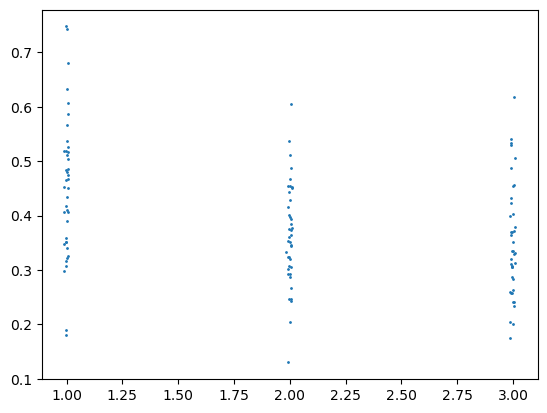

In [15]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [16]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [17]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(121, 3)


In [18]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [19]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [21]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.62it/s]


Loss: 398.11602703877725
Average Loss: 0.05447674152145283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.68it/s]


Loss: 398.1843072704505
Average Loss: 0.054486084738704234
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.77it/s]


Loss: 398.30006284848787
Average Loss: 0.05450192430876955
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.44it/s]


Loss: 398.332360120723
Average Loss: 0.05450634374941475
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.56it/s]


Loss: 398.19164350186475
Average Loss: 0.054487088601787734
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.93it/s]


Loss: 398.2915080199018
Average Loss: 0.054500753697304574
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.71it/s]


Loss: 398.0615205497015
Average Loss: 0.054469283052777984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.04it/s]


Loss: 398.31411344348453
Average Loss: 0.05450384694081616
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.41it/s]


Loss: 398.11828573746607
Average Loss: 0.054477050593523
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.70it/s]


Loss: 398.1600000062026
Average Loss: 0.054482758621538396
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 3


  2%|███▌                                                                                                                                                          | 164/7308 [00:02<00:40, 174.98it/s]

X_batch: 
torch.Size([128, 121])
tensor([[0.1409, 0.0324, 0.0414,  ..., 0.1079, 0.0509, 0.0599],
        [0.5153, 0.2267, 0.1833,  ..., 0.5186, 0.2314, 0.2588],
        [0.3014, 0.1176, 0.1164,  ..., 0.1159, 0.2092, 0.1265],
        ...,
        [0.3781, 0.4264, 0.1147,  ..., 0.5433, 0.4900, 0.2538],
        [0.0331, 0.0123, 0.0420,  ..., 0.0858, 0.0558, 0.0528],
        [0.3596, 0.1829, 0.1063,  ..., 0.3761, 0.1620, 0.0969]])
X_pred: 
torch.Size([128, 121])
tensor([[0.1278, 0.0500, 0.0334,  ..., 0.1294, 0.0496, 0.0360],
        [0.5136, 0.2567, 0.1868,  ..., 0.4793, 0.2898, 0.2696],
        [0.2867, 0.1519, 0.1221,  ..., 0.2152, 0.2139, 0.1962],
        ...,
        [0.3871, 0.3769, 0.1485,  ..., 0.4801, 0.3904, 0.1013],
        [0.0730, 0.0294, 0.0203,  ..., 0.0748, 0.0295, 0.0223],
        [0.3546, 0.1863, 0.1164,  ..., 0.3572, 0.1910, 0.1422]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.75it/s]


Loss: 398.0311081795953
Average Loss: 0.0544651215352484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.87it/s]


Loss: 397.9696110051591
Average Loss: 0.05445670648674864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.14it/s]


Loss: 398.0895894235
Average Loss: 0.05447312389484127
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.35it/s]


Loss: 398.10264890664257
Average Loss: 0.05447491090676554
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.75it/s]


Loss: 398.0992186234798
Average Loss: 0.05447444151935958
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.87it/s]


Loss: 397.9272593134083
Average Loss: 0.05445091123609856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.76it/s]


Loss: 397.9643108244054
Average Loss: 0.054455981229393186
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.50it/s]


Loss: 397.8631974873133
Average Loss: 0.05444214525004287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.79it/s]


Loss: 397.8268954446539
Average Loss: 0.05443717781125533
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.76it/s]


Loss: 398.0525912507437
Average Loss: 0.0544680612001565
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.27it/s]


Loss: 397.8387572544161
Average Loss: 0.05443880093793324
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.94it/s]


Loss: 397.8183798987884
Average Loss: 0.0544360125750942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.79it/s]


Loss: 397.8471475064289
Average Loss: 0.05443994902934166
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.86it/s]


Loss: 398.0066028770525
Average Loss: 0.05446176831924637
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.30it/s]


Loss: 397.8419006119948
Average Loss: 0.05443923106349135
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.22it/s]


Loss: 398.03937232284807
Average Loss: 0.05446625237039519
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.56it/s]


Loss: 397.7108733130153
Average Loss: 0.054421301766969805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.82it/s]


Loss: 397.7305410276167
Average Loss: 0.05442399302512544
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.30it/s]


Loss: 397.9343684206251
Average Loss: 0.054451884020337314
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.94it/s]


Loss: 397.7910215300508
Average Loss: 0.05443226895594565
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.86it/s]


Loss: 397.77870923955925
Average Loss: 0.05443058418713181
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.33it/s]


Loss: 397.8470125333406
Average Loss: 0.05443993056011776
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.98it/s]


Loss: 397.74517680774443
Average Loss: 0.05442599573176579
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.20it/s]


Loss: 397.71846807491966
Average Loss: 0.054422341006420315
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.76it/s]


Loss: 397.8709218238946
Average Loss: 0.054443202220018416
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.70it/s]


Loss: 397.5788792865351
Average Loss: 0.054403240186991664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.79it/s]


Loss: 397.7885286384262
Average Loss: 0.05443192783777042
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.74it/s]


Loss: 397.6014856577385
Average Loss: 0.05440633356017221
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.21it/s]


Loss: 397.71396557590924
Average Loss: 0.05442172490091807
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.40it/s]


Loss: 397.6622363019269
Average Loss: 0.054414646456202365
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.76it/s]


Loss: 397.8137184414081
Average Loss: 0.054435374718309816
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.99it/s]


Loss: 397.5547555817757
Average Loss: 0.0543999391874351
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.81it/s]


Loss: 397.7232801821083
Average Loss: 0.054422999477573654
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.82it/s]


Loss: 397.54681444889866
Average Loss: 0.05439885255184711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.85it/s]


Loss: 397.47144581680186
Average Loss: 0.05438853938379883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.30it/s]


Loss: 397.5939504907001
Average Loss: 0.05440530247546525
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.81it/s]


Loss: 397.61580174439587
Average Loss: 0.054408292521126965
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.34it/s]


Loss: 397.5681271003559
Average Loss: 0.054401768897147776
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.62it/s]


Loss: 397.4937238341663
Average Loss: 0.0543915878262406
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.62it/s]


Loss: 397.6587136739399
Average Loss: 0.0544141644326683
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.50it/s]


Loss: 397.5527467171196
Average Loss: 0.0543996643017405
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.88it/s]


Loss: 397.1372260970529
Average Loss: 0.05434280597934495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.88it/s]


Loss: 397.4397904430516
Average Loss: 0.054384207778195345
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.09it/s]


Loss: 397.6430557779968
Average Loss: 0.05441202186343689
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.93it/s]


Loss: 397.4801425382029
Average Loss: 0.054389729411357814
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.44it/s]


Loss: 397.5251742915716
Average Loss: 0.054395891391840666
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.24it/s]


Loss: 397.5435411320068
Average Loss: 0.05439840464313175
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.30it/s]


Loss: 397.4437953957822
Average Loss: 0.05438475580128383
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.07it/s]


Loss: 397.4530747963581
Average Loss: 0.05438602556053067
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.46it/s]


Loss: 397.4336966110859
Average Loss: 0.05438337392050984
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.41it/s]


Loss: 397.51578721776605
Average Loss: 0.05439460689898277
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.58it/s]

Loss: 397.31209888029844
Average Loss: 0.05436673493162267
Done, best loss: 397.1372260970529
Done


<All keys matched successfully>

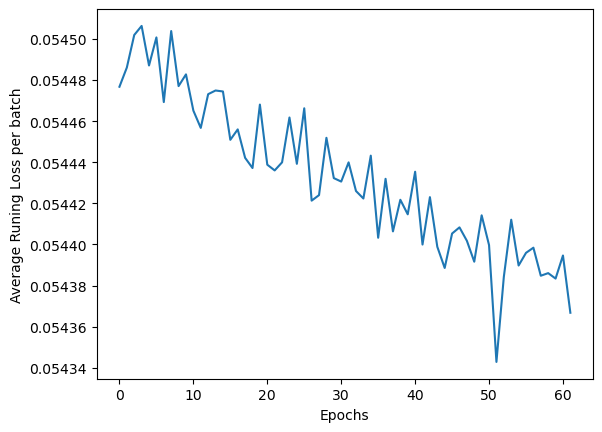

In [22]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [23]:
torch.save(final_model, 'model_100206_8g_03.pt')